## **Load in data**

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pylab
from scipy.optimize import minimize

from GP import * 
from vis import *
from data import * 

# Outputs are t, y, ttrue, ytrue
t, y, ttrue, ytrue = loadData()


NameError: name 'loadData' is not defined

## **Initial Test**

Hyperparameters chosen manually to provide a reasonable fit to the data, using a summed RBF kernel and periodic kernel.


Log marginal likelihood: 899.1284396472093
RMSE:  37.9807748619382





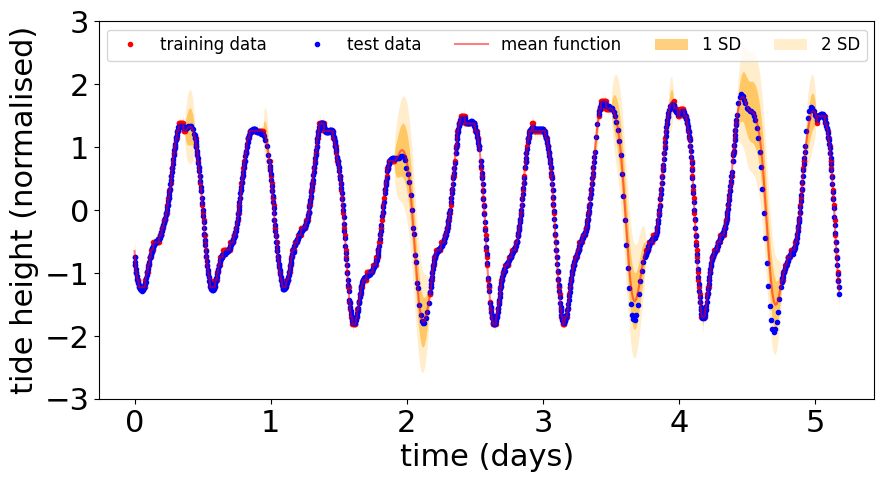

In [3]:

# Input data for GP
X = t
Y = y 
# Xs = np.linspace(-1, 6, 500).reshape(-1,1) 
Xs = ttrue

# Initial guess for model parameters
sigma_rbf = 0.5 # RBF kernel
L_rbf = 0.2

sigma_per = 1  # periodic kernel
L_per = 0.4
p_per = 0.5175

jitter = 0.01

# Parameters from optimizer result
# jitter, sigma_rbf, L_rbf, sigma_per, L_per, p_per = 0.02313429, -0.32364286,  0.46129201,  0.62726026,  0.80954964,  0.51560234

# Build the kernel function
params = [jitter, sigma_rbf, L_rbf, sigma_per, L_per, p_per]
kernel = buildKernel(params)

# Mean and covariance functions
mu = np.zeros(len(X))
K = kernel(X, X)

# Posterior predictive distribution
mu, sigma, LML = getPosteriorPredictive(X, Y, Xs, kernel, jitter)

# Compute RMSE
RMSE = getRMSE(mu, ytrue)

# Printouts
print("Log marginal likelihood:", LML)
print('RMSE: ', RMSE)

# Visualisation
plotTides(Xs, mu, sigma, t, y, ttrue, ytrue)



## Optimisation of Log Marginal Likelihood


LML: 899.1284396472093
LML: 899.1284255969791
LML: 899.1284171235862
LML: 899.1284940752158
LML: 899.1284394553587
LML: 899.1284412422848
LML: 899.12840608104
         Current function value: -899.128440
         Iterations: 0
         Function evaluations: 7
         Gradient evaluations: 1
initial guess:  [0.01, 0.5, 0.2, 1, 0.4, 0.5175]
final parameters: 0.01,0.5,0.2,1.0,0.4,0.5175
Log marginal likelihood: 899.1284396472093
RMSE:  37.9807748619382





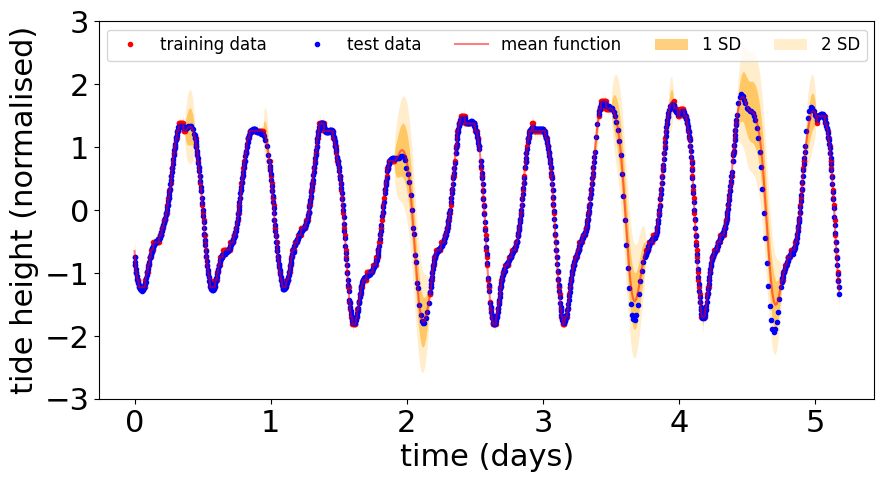

In [4]:
# Input data for GP
X = t
Y = y 
# Xs = np.linspace(-1, 6, 500).reshape(-1,1) 
Xs = ttrue

# Initial guess for model parameters
sigma_rbf = 0.5 # RBF kernel
L_rbf = 0.2

sigma_per = 1  # periodic kernel
L_per = 0.4
p_per = 0.5175

jitter = 0.01

init_guess = [jitter, sigma_rbf, L_rbf, sigma_per, L_per, p_per]

max_iter = 0
result = minimize(
    optimizerFunction, 
    init_guess, 
    args=(X, Y, Xs), 
    method='BFGS', 
    tol=0.01,
    options={"maxiter":max_iter, "disp":True})
# optimize.minimize(

print("initial guess: ", init_guess)
    
print("final parameters: ", end='')
print(*result.x, sep=',')

# Build the kernel function
params = result.x
kernel = buildKernel(params)

# Mean and covariance functions
mu = np.zeros(len(X))
K = kernel(X, X)

# Posterior predictive distribution
jitter = params[0]
mu, sigma, LML = getPosteriorPredictive(X, Y, Xs, kernel, jitter)

# Compute RMSE
RMSE = getRMSE(mu, ytrue)

# Printouts
print("Log marginal likelihood:", LML)
print('RMSE: ', RMSE)

# Visualisation
plotTides(Xs, mu, sigma, t, y, ttrue, ytrue)

## Look-ahead experiments

We choose some lookahead time $\delta_t$. Then, for each available data point at time $t$ in the ground truth dataset, we try to predict its value using only data from before time $t - \delta_t$.

Finished iteration 100 of 1258
Finished iteration 200 of 1258
Finished iteration 300 of 1258
Finished iteration 400 of 1258
Finished iteration 500 of 1258
Finished iteration 600 of 1258
Finished iteration 700 of 1258
Finished iteration 800 of 1258
Finished iteration 900 of 1258
Finished iteration 1000 of 1258
Finished iteration 1100 of 1258
Finished iteration 1200 of 1258





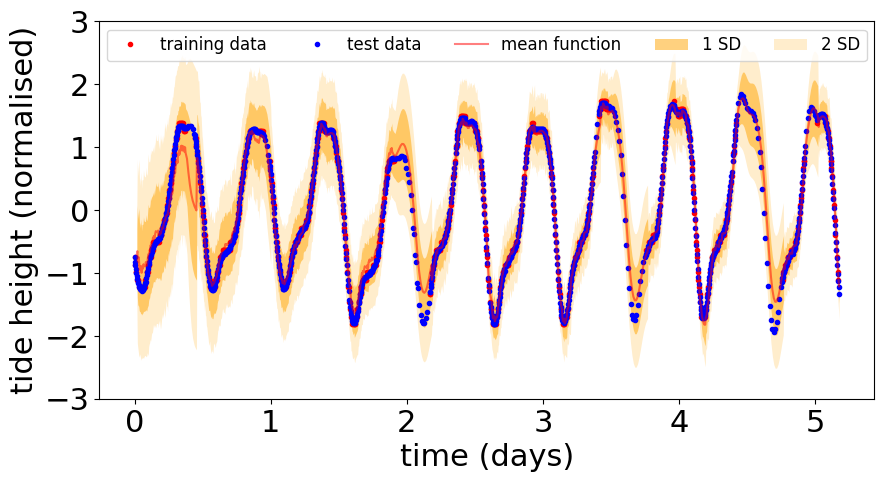

In [5]:
# Lookahead period in minutes
lookahead = 15 # 3*24*60
dt = lookahead / (60 * 24) # days

# Total available data
pts = len(ttrue)

# Start predicting from the nth datapoint onwards
first = 1

# Plotting arrays
tvals = ttrue[first-1:]
yvals, muvals, sigmavals, Xsvals= np.array([]), np.array([]), np.array([]), np.array([])

# Progress printing
pskip = 100

# Predict tide height at each time t based only on data from time t-dt or earlier
for i in range(first-1, pts):

    # Progress printout
    iter = i - first + 1
    if iter > 0 and iter % pskip == 0:
        print("Finished iteration", i-first+1, "of", pts-first+1)
    
    # Time to predict for
    target_time = ttrue[i]

    # Find latest data point to use for lookahead
    j = 0
    while j < len(t) and t[j] + dt < target_time:
        j += 1

    # Too early in dataset to look ahead - skip
    if ttrue[i] < dt or j == 0: 
        continue 

    # Extract data used for lookahead
    X = t[:j]
    Y = y[:j]

    # Target X* is a single point
    Xs = np.array([target_time])

    # Build kernel
    params = [0.01, 0.5, 0.2, 1.0, 0.4, 0.5175]
    kernel = buildKernel(params)

    # Posterior predictive distribution
    jitter = params[0]
    mu, sigma, LML = getPosteriorPredictive(X, Y, Xs, kernel, jitter)

    # Sanity checking
     # jj = 0
    # while t[jj] < target_time:
    #     jj += 1

   # print(t[jj], target_time) # should be always equal
    # print("Time lookahead gap (hrs): ", 24 * (target_time - X[-1])) # check lookahead time
    # print("Compare:", mu, ytrue[jj])

    # Store variables for plotting
    ii = i - first + 1
    muvals = np.append(muvals, mu)
    sigmavals = np.append(sigmavals, sigma)
    Xsvals = np.append(Xsvals, Xs)

# For the covariance matrix, we are interested in the diagonal terms only 
sigma_matrix = np.diag(sigmavals)

# Visualisation
plotTides(Xsvals, muvals, sigma_matrix, t, y, ttrue, ytrue)

